Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from typing import List, Optional
from anytree import Node, RenderTree

In [2]:
X = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])

query_pt = ([7, 4])

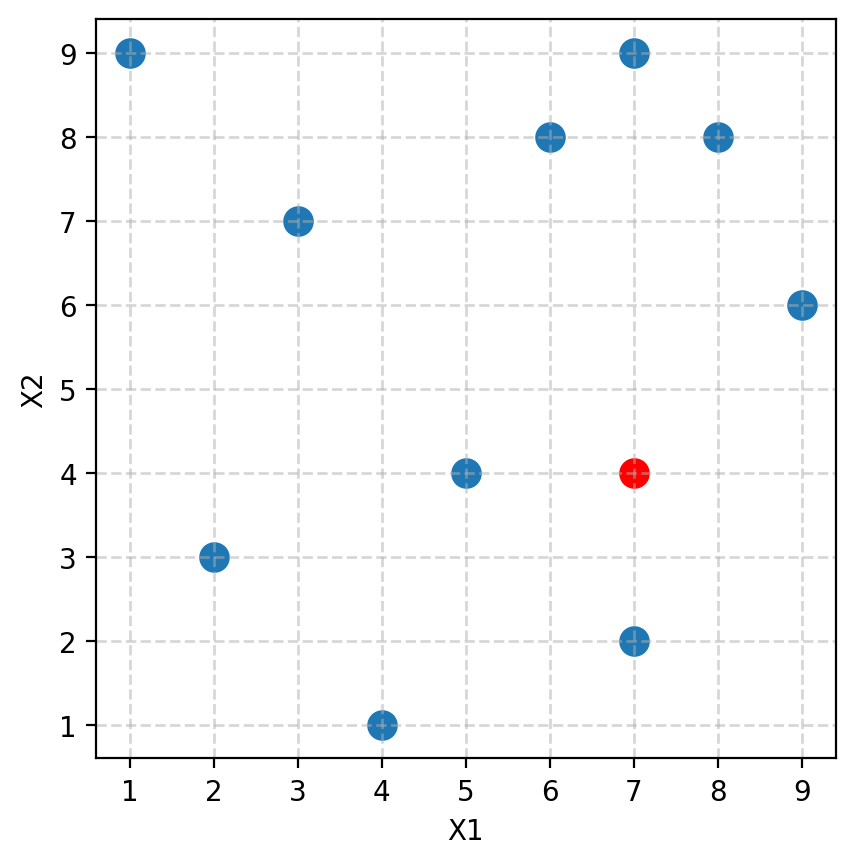

In [3]:
def plot_dataset():
    plt.scatter(X[:, 0], X[:, 1], s=100)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=0.5)
    plt.xticks(np.arange(min(X[:, 0]), max(X[:, 0])+1, 1))
    plt.yticks(np.arange(min(X[:, 1]), max(X[:, 1])+1, 1))
    
    plt.scatter(query_pt[0], query_pt[1], color='red', s=100)
    

plot_dataset()
    

KNN from Sci-kit learn

In [4]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, algorithm='brute').fit(X)
distances, indices = nbrs.kneighbors([query_pt])

In [5]:
indices, X[indices], distances

(array([[4, 6]], dtype=int64),
 array([[[5, 4],
         [7, 2]]]),
 array([[2., 2.]]))

Using the naive KNN approach

In [6]:
def pairwise_dist(x: np.ndarray, y: np.ndarray) -> float:
    """
        x: numpy array of shape(d, )
        y: numpy array of shape(d, )
        
        returns the euclidean distance between two d dimensionsal arrays x and y
    """
    return np.sqrt(np.sum((x-y)**2))
    

In [7]:
def distance_vector(X: np.ndarray, y:np.ndarray) -> np.ndarray:
    """
        X: numpy array of shape(n, d)
        query_pt: numpy array of shape(d, )
        
        returns the distance of query_pt from all the points in X
    """
    
    n, d = X.shape
    distances = np.zeros(n)
    for i in range(n):
        distances[i] = pairwise_dist(X[i], query_pt)
    return distances

In [8]:
distances = distance_vector(X, query_pt)

In [9]:
distance_table = pd.DataFrame({
    "Point" : X.tolist(),
    "Distance" : distances
})

In [10]:
distance_table

,Point,Distance
0,"[1, 9]",7.810250
1,"[2, 3]",5.099020
2,"[4, 1]",4.242641
3,"[3, 7]",5.000000
4,"[5, 4]",2.000000
5,"[6, 8]",4.123106
6,"[7, 2]",2.000000
7,"[8, 8]",4.123106
8,"[7, 9]",5.000000
9,"[9, 6]",2.828427


We can see that the minimum distances for the points [5,4] and [7,2]. There are the nearest neighbours and it is the same result as obtained with the sklearn implementation

In [11]:
distance_table.sort_values(by=['Distance'])

,Point,Distance
4,"[5, 4]",2.000000
6,"[7, 2]",2.000000
9,"[9, 6]",2.828427
5,"[6, 8]",4.123106
7,"[8, 8]",4.123106
2,"[4, 1]",4.242641
3,"[3, 7]",5.000000
8,"[7, 9]",5.000000
1,"[2, 3]",5.099020
0,"[1, 9]",7.810250


Using KD trees

In [15]:
class KDNode:
    def __init__(self, point=None, points=None, dim=None, left=None, right=None):
        """
            point: The coordinate of the point represented by this node
            left: The left child
            right: The right child
            dim: The dimension used to split the data
            points: The set of points stored at the leaf node
        """
        self.point = point
        self.points = points
        self.dim = dim
        self.left = left
        self.right = right

    def __repr__(self):
        return f"KDNode(point={self.point}, dim={self.dim})"

class KDTree:
    def __init__(self, min_samples_split=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.X = None
        self.n_dimensions = None
        
    def build(self, X: np.ndarray):
        """
        Builds the KD-tree from input data
        
        Parameters:
        -----------
        X : np.ndarray
            Input data of shape (n_samples, n_features)
        """
        self.X = X
        self.n_dimensions = X.shape[1]
        self.root = self.split(X)
        
    def fit(self, X: np.ndarray):
        """
        Alias for build method to maintain consistency with sklearn-style interface
        """
        return self.build(X)
        
    def split(self, X: np.ndarray, depth: int = 0) -> Optional[KDNode]:
        if len(X) == 0:
            return None
            
        if len(X) < self.min_samples_split:
            return KDNode(point=X[0], points=X, dim=None)
        
        # Select dimension based on depth
        dim = depth % self.n_dimensions
        
        # Sort points along the chosen dimension
        sorted_idx = X[:, dim].argsort()
        X_sorted = X[sorted_idx]
        
        # Find median index
        median_idx = len(X_sorted) // 2
        
        # Handle cases where there are duplicate values at the median
        median_val = X_sorted[median_idx, dim]
        
        # Split the data
        left_mask = X_sorted[:, dim] < median_val
        right_mask = X_sorted[:, dim] > median_val
        median_mask = X_sorted[:, dim] == median_val
        
        # Distribute points equal to median between left and right
        median_points = X_sorted[median_mask]
        median_split = len(median_points) // 2
        
        left_points = X_sorted[left_mask]
        if len(median_points) > 0:
            left_points = np.vstack([left_points, median_points[:median_split]]) if len(left_points) > 0 else median_points[:median_split]
        
        right_points = X_sorted[right_mask]
        if len(median_points) > median_split:
            right_points = np.vstack([median_points[median_split:], right_points]) if len(right_points) > 0 else median_points[median_split:]
        
        # Create node
        node = KDNode(
            point=X_sorted[median_idx],
            dim=dim,
            left=self.split(left_points, depth + 1) if len(left_points) > 0 else None,
            right=self.split(right_points, depth + 1) if len(right_points) > 0 else None
        )
        
        # If this becomes a leaf node, store all points
        if node.left is None and node.right is None:
            node.points = X_sorted
            
        return node
    
    def print_tree(self):
        """
        Prints a visual representation of the KD-tree structure
        """
        def print_node(node, level=0, prefix="Root: "):
            if node is None:
                return
            
            indent = "  " * level
            if node.points is not None:
                print(f"{indent}{prefix}Leaf with {len(node.points)} points")
            else:
                print(f"{indent}{prefix}Split on dim {node.dim} at value {node.point[node.dim]:.2f}")
                if node.dim == 0:
                    print(f"{indent}  (x-axis split)")
                else:
                    print(f"{indent}  (y-axis split)")
            
            if node.left:
                print_node(node.left, level + 1, "Left:  ")
            if node.right:
                print_node(node.right, level + 1, "Right: ")
        
        print("\nKD-Tree Structure:")
        print("-" * 50)
        print_node(self.root)
        
        # Print split statistics
        splits_per_dim = self.count_splits_per_dim()
        print("\nSplit Statistics:")
        print("-" * 50)
        for dim in range(self.n_dimensions):
            print(f"Dimension {dim} splits: {int(splits_per_dim[dim])}")
        print("-" * 50)
        
    def count_splits_per_dim(self):
        """
        Counts the number of splits per dimension
        """
        def count_node_splits(node, counts=None):
            if counts is None:
                counts = np.zeros(self.n_dimensions)
            
            if node is None or node.dim is None:
                return counts
            
            counts[node.dim] += 1
            counts = count_node_splits(node.left, counts)
            counts = count_node_splits(node.right, counts)
            return counts
        
        return count_node_splits(self.root)
    
    def find_leaf_points(self, query_point: np.ndarray) -> np.ndarray:
        def search(node: Optional[KDNode]) -> Optional[np.ndarray]:
            if node is None:
                return None
                
            if node.left is None and node.right is None:
                return node.points
                
            if query_point[node.dim] <= node.point[node.dim]:
                return search(node.left)
            else:
                return search(node.right)
                
        points = search(self.root)
        return points if points is not None else np.array([])
    
    def k_nearest(self, query_point: np.ndarray, k: int) -> np.ndarray:
        """ Finds the k nearest neighbors to the query_point within the leaf node.

            Parameters:
            -----------
            query_point : np.ndarray
                The point for which to find the k nearest neighbors.
            k : int
                The number of nearest neighbors to find.
                
            Returns:
            --------
            np.ndarray
                The k nearest points in the leaf node, or all points if the number is less than k.
        """
    
        leaf_points = self.find_leaf_points(query_point)
        
        if len(leaf_points) <= k:
            return leaf_points
        
        distances = [pairwise_dist(query_point, point) for point in leaf_points]
        
        k_nearest_indices = np.argsort(distances)[:k]
        
        return leaf_points[k_nearest_indices]

    def knn_naive(self, query_point: np.ndarray, k: int) -> np.ndarray:
        """
        Finds the 3 nearest neighbors to the query_point using a simple KNN approach.

        Parameters:
        -----------
        query_point : np.ndarray
            The point for which to find the 3 nearest neighbors.

        Returns:
        --------
        np.ndarray
            The 3 nearest points in self.X to the query_point.
        """
        distances = np.linalg.norm(self.X - query_point, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        return self.X[nearest_indices]

    def plot_tree(self, query_point: np.ndarray = None, k: int = None):
        """
        Plots the KD-tree partitions and optionally highlights the query point
        and k nearest neighbors, as well as 3 nearest neighbors found using simple KNN.
        
        Parameters:
        -----------
        query_point : np.ndarray, optional
            The point for which to find and highlight the k nearest neighbors.
        k : int, optional
            The number of nearest neighbors to highlight in KD-tree.
        """
        
        fig, ax = plt.subplots()
        
        ax.scatter(self.X[:, 0], self.X[:, 1], color='blue', label='All Points')
        
        if query_point is not None and k is not None:
            nearest_neighbors = self.k_nearest(query_point, k)
            
            ax.scatter(query_point[0], query_point[1], color='green', marker='*', s=150, label='Query Point')
            
            ax.scatter(nearest_neighbors[:, 0], nearest_neighbors[:, 1], color='red', label=f'{k} Nearest Neighbors (KD-Tree)')

            knn_nearest_neighbors = self.knn_naive(query_point, k)
            ax.scatter(knn_nearest_neighbors[:, 0], knn_nearest_neighbors[:, 1], color='purple', marker='x', s=100, label='3 Nearest Neighbors (KNN)')

        def plot_partitions(node, x_min, x_max, y_min, y_max, depth=0):
            if node is None:
                return
            
            dim = depth % self.n_dimensions
            if dim == 0:  
                x_split = node.point[0]
                ax.plot([x_split, x_split], [y_min, y_max], color='black', linestyle='--', linewidth=0.5)
                
                plot_partitions(node.left, x_min, x_split, y_min, y_max, depth + 1)
                plot_partitions(node.right, x_split, x_max, y_min, y_max, depth + 1)
            
            else:  
                y_split = node.point[1]
                ax.plot([x_min, x_max], [y_split, y_split], color='black', linestyle='--', linewidth=0.5)
                
                plot_partitions(node.left, x_min, x_max, y_min, y_split, depth + 1)
                plot_partitions(node.right, x_min, x_max, y_split, y_max, depth + 1)
        
        plot_partitions(self.root, x_min=self.X[:, 0].min(), x_max=self.X[:, 0].max(),
                        y_min=self.X[:, 1].min(), y_max=self.X[:, 1].max())
        
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title('KD-Tree with Partitions and Optional Nearest Neighbors')
        ax.legend()
        plt.show()

In [13]:
np.random.seed(42)
X = np.random.rand(100, 2) * 10

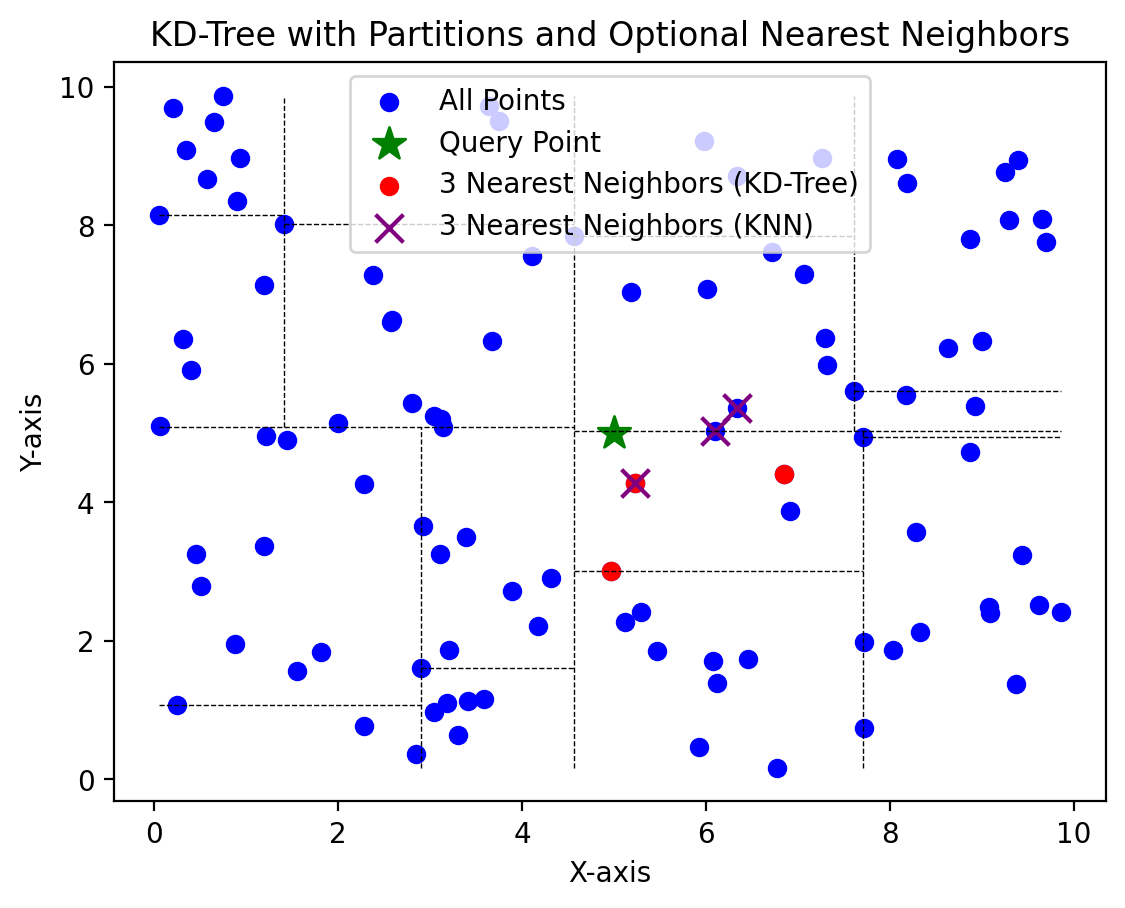

In [ ]:
tree = KDTree(min_samples_split=20)
tree.build(X)

query_point = np.array([5, 5])
k = 3
tree.plot_tree(query_point=query_point, k=k)